# Week 5 - Regression Modeling

### Aims

By the end of this notebook you will be able to understand 

>* the different types of regression
>* the rank deficiency issue
>* the main regularization ideas (Ridge and Lasso) 
>* the basics of polynomial regression

1. [General Setup](#setup)

2. [Least squares Estimation](#RBH)

3. [Regression using scikit-Learn](#RSKL)

4. [Regression with categorical cariables](#SKV)

5. [Multiple linear regression](#MLR)

6. [Regularization](#Reg)

This week we will be implementing the linear regression techniques. For this purpose, the main data set is called `insurance.csv` in the upcoming code snippets. You will have tasks tagged by (CORE) and (EXTRA).

Regarding the submission of weekly hands-in; 

>- Please submit a pdf of your notebook on Learn page by 16:00 PM on the Friday of the week the workshop was given.
>- You don't need to finish everything, but you should have had a substantial attempt at the bulk of the material. 
>- In general, you can aim to complete all the (CORE) tasks.
>- For this submission, you can simply select the print option in your browser which should generate a high-quality pdf of your complete notebook. 
>- Basically, right click → Click Print → Choose 'Save as PDF' option instead of default printing destination (Check that your all materials are visible in the print preview) → Click 'Save' to get your pdf file

---

# 1. General Setup <a id='setup'></a>

## 1.1 Packages

Now let us load the packages you wil need for this workshop.

In [1]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules and some other will be added later
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
# Plotting defaults for all Figures below
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

## 1.2  User Defined Helper Functions

Below are two helper functions we will be using in this workshop. You can create your own if you think it is necessary OR directly use already available helper functions within `sklearn library`. 

These practices would be important while you are working on your project either. 

- `get_coefs()`: Simple function that concatenates both the intercept and other coefficients from a `sklearn object`
- `model_fit()`: Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values with plotting as add-on.

You can modify the following functions based on your needs as well. 

In [3]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

In [4]:
def model_fit(m, X, y, plot = False):
    """Returns the mean squared error, root mean squared error and R^2 value of a fitted model based 
    on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    MSE = mean_squared_error(y, y_hat)
    RMSE = np.sqrt(mean_squared_error(y, y_hat))
    Rsqr = r2_score(y, y_hat)
    
    Metrics = (round(MSE, 4), round(RMSE, 4), round(Rsqr, 4))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Actual vs Fitted plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y_hat', y='resid', data=res).set_title("Fitted vs Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model (MSE, RMSE, Rsqr) = " + str(Metrics), fontsize=14)
        plt.show()
    
    return MSE, RMSE, Rsqr

## 1.3 Data Set 

To begin, we will examine `insurance.csv` data set on the medical costs which comes from the `Medical Cost Personal` data set. Our goal is to model the yearly medical charges of an individual using some combination of the other features in the data. The included columns are as follows:

* `charges` - yearly medical charges in USD
* `age` - the individuals age
* `sex` - the individuals sex, either `"male"` or `"female"`
* `bmi` - the body mass index of the individual
* `children` - the number of dependent children the individual has
* `smoker` - a factor with levels `"yes"`, the individual is a smoker and `"no"`, the individual is not a smoker

We read the data into python using pandas.


In [5]:
df_insurance = pd.read_csv("insurance.csv")
df_insurance[:5]

,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520


The general descriptions and the details on variables can be derived first. Besides, we can construct a pairs plot of our data and examining the relationships between our variables.

---

### 🚩 Exercise 1 (CORE)

- Examine the data structure and look at the descriptive statistics. Decide types of variables in the data set. 
- Create a pairs plot of these data (make sure to include the `smoker` column), describe any relationships you observe in the data.

<details><summary><b><u>Hint</b></u></summary>
    
- <code>.describe()</code> can be used to create summary descriptive statistics on a pandas dataframe.
- You can use a <code>sns.pairplot</code> with the hue argument
    
</details>

---

Add your text solution here


# 2. Least Squares Estimation <a id='RBH'></a>

Consider a simple linear regression model for `charges` exclusively using `bmi` as a feature in our model. Without sklearn functionalities, we can follow the general formulation that we discussed in the lecture, using the design matrix idea

### 🚩 Exercise 2 (CORE)

Create a scatter plot using the `insurance_df` data frame describe any apparent relationship between `charges` and `bmi` (make sure to include the smoker `column`). What do you think about the possible relationshop ? 

In lecture we discussed how we can represent a regression problem using matrix notation and we can derive a solution using least squares. We can express this as,

$$
\underset{\boldsymbol{\beta}}{\text{argmin}} \,\, \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 
= \underset{\boldsymbol{\beta}}{\text{argmin}} \,\, (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta})^\top(\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta})
$$

where,

$$
\underset{n \times 1}{\boldsymbol{y}} = \begin{pmatrix} y_1 \\ y_2 \\ \vdots \\ y_{n-1} \\ y_n \end{pmatrix} 
\qquad
\underset{n \times 2}{\boldsymbol{X}} = \begin{pmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_{n-1} \\ 1 & x_n \\ \end{pmatrix}
\qquad 
\underset{2 \times 1}{\boldsymbol{\beta}} = \begin{pmatrix} \beta_0 \\ \beta_1 \end{pmatrix}
$$

The solution to this optimization problem is,

$$
\boldsymbol{\beta} = \left(\boldsymbol{X}^\top\boldsymbol{X}\right)^{-1} \boldsymbol{X}^\top\boldsymbol{y}
$$

In Python we can construct the model matrix `X` by combining a column of ones, for the intercept, with our observed `bmi` values. Similarly, `y` is a column vector of the `charges` values. In both cases we construct these objects as numpy array objects.

### 2.1 Train / Test Split
First, as always, we will split our data into two distinct sets. The first called the `training set` will contain our test data `X_train` and `y_train` which is used for determining the feature weights. The second called the `test set` will contain our testing data `X_test` and `y_test`

In [6]:
# As a good practice first split the data
from sklearn.model_selection import train_test_split

X = df_insurance.drop('charges', axis = 1) # Set of features
y = df_insurance['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_test.head()

,age,sex,bmi,children,smoker
764,45,female,25.175,2,no
887,36,female,30.020,0,no
890,64,female,26.885,0,yes
1293,46,male,25.745,3,no
259,19,male,31.920,0,yes


In [7]:
# Converting response training object to numpy array
y = np.array(y_train)
print(y[:5])

[13429.0354  24603.04837 27322.73386 42303.69215 42112.2356 ]


In [8]:
# Writing the design matrix for a selected predictor, only bmi here
X = np.c_[
    np.ones(len(X_train)),
    X_train.bmi
]

print(X[:5])

[[ 1.    31.16 ]
 [ 1.    27.6  ]
 [ 1.    31.9  ]
 [ 1.    30.685]
 [ 1.    45.54 ]]


Given the model matrix (desig matrix) $(\boldsymbol{X})$ and observed outcomes $(\boldsymbol{y})$ we can then calculate the vector of solutions $(\boldsymbol{\beta})$ using numpy,

In [9]:
from numpy.linalg import solve
beta = solve(X.T @ X, X.T @ y)
print(beta)

[1397.62727652  392.30159999]


- Note that when using numpy `@` performs  matrix multiplication while `*` performs elementwise multiplication between arrays. 
- Numpy matrix multiplication can also be written using `A.dot(B)` or `np.matmul(A,B)`.

We can calculate predictions from this model by calculating $\hat{y} = \boldsymbol{X} \boldsymbol{\beta}$. 

---

### 🚩 Exercise 3 (CORE)

Calculate these predicted charges and store them in the origin `X_train` data frame in a column called `charges_pred`. Print out the updated version of the data frame with this new column added.

---

Given the predictions we can create a plot showing the models fit by overlaying a line plot of the predictions on top of the original scatter plot.

In [ ]:
X_train["actual"] = y_train
sns.scatterplot(x = "bmi", y = "actual", hue = "smoker", data = X_train)
sns.lineplot(x = "bmi", y = "charges_pred", color = "black", data = X_train)

### 2.2 About Residuals

From the figure above, do you think that this model is a good fit? 

- One of the most useful tools for evaluating a model is to examine the residuals of that model. For any standard regression model the residual for observation $i$ is defined as $y_i - \hat{y}_i$ where $\hat{y}_i$ is the model's predicted value for observation $i$. As mentioned previous, for the case of linear regression
$\hat{y} = \boldsymbol{X} \boldsymbol{\beta}$.

To calculate the residual for each observation and store them in the origin `X_train` data frame in a column called named `resid`. Using this new column, we can create a residual plot (scatter plot of volume vs resid) for this model. It is possible to color the points based on weather the individual is a smoker or not.

In [ ]:
X_train['resid'] = X_train.actual - X_train.charges.pred
sns.scatterplot(x = "charges_pred", y = "resid", hue = "smoker", data = X_train)

Studying the properties of the residuals is important for assessing the quality of the fitted regression model. This scatterplot (residual vs. fitted) gives us more intuition about the model performance. Briefly, 

>- If the linear assumption is true then the residuals should be randomly scattered around zero with no discernible clustering or pattern with respect to the fitted values. 
>- Furthermore, this plot can be useful to check the constant variance (homoscedastic) assumption to see whether the range of the scatter of points is consistent over the range of fitted values.

### 🚩 Exercise 4 (CORE)

Calculate the $R^2$ score for the above model and comment on the value which you obtain.

<details><summary><b><u>Hint</b></u></summary>
    
The $R^2$ (also called the coefficient of determination) statistic provides an alternative measure of evaluating the usefullness of the model. It takes the form of a proportion, the proportion of variance explained by the independent variable. To calculate the coefficient of determination ($R^2$), one can use the formula 

$$R^2 = 1- \frac{RSS}{TSS} = \frac{\sum_{i=1}^{N}(y_i -\hat{y}_i)^2}{\sum_{i=1}^{N}(y_i -\overline{y})^2}$$ 
    
</details>

---
# 3 Regression using scikit-Learn <a id='RSKL'></a>

>* Constructing the model matrix by hand and calculating $\boldsymbol{\beta}$ and model predictions using the least squares solution is less than ideal. As you might expect, we will be using the **scikit-learn** (**sklearn**) library to implement most of our machine learning models.  
>* For today, mainly, we will be using the `LinearRegression` helper function from the `linear_model` submodule.

In [10]:
from sklearn.linear_model import LinearRegression

In general sklearn's models are implemented by first creating a model object, which is configured via constructor arguments, and then using that object to fit your data. As such, we will now create a linear regression model object `lr` and use it to fit our data. Once this object is created we use the `fit` method to obtain a model object fitted to our data. 

In [15]:
lin_reg = LinearRegression()

linear_fit = lin_reg.fit(
    # X must be a matrix so we need to reshape the column
    X = np.array(X_train.bmi).reshape(-1,1), 
    y = y_train
)

This model object then has various useful methods and attributes, including `intercept_` and `coef_` which contain our estimates for $\boldsymbol{\beta}$.

In [16]:
beta_0 = linear_fit.intercept_  # Intercept term of the fitted model
beta_1 = linear_fit.coef_[0]   # Subsetting here returns a scalar value

beta = (beta_0, beta_1)
print(beta)

(1397.6272765244848, 392.30159998842424)


Using this default construction of `LinearRegression`, sklearn assumes that we have not included an intercept column (ones) in our model matrix and takes care of this for you. Additionally, since the intercept column is added the $\beta$ estimated for this particular column is stored separately, in the `intercept_` attribue. It is also possible to retrieve all `beta` values (including the intercept) from `coef_` directly by setting `fit_intercept=False` and re-construct the `LinearRegression` object

The model fit objects also provide additional useful methods for evaluating the model $R^2$ (`score`) and calculating predictions (`predict`). Using the later we can add another column of predictions to our data frame.

In [20]:
y_pred = linear_fit.predict(np.array(X_train.bmi).reshape(-1,1))

# The mean squared error of the training set 
print("Mean squared error: %.3f" % mean_squared_error(y_train, y_pred))
# The coefficient of determination of the training set 
print("Coefficient of determination: %.3f" % r2_score(y_train, y_pred))

# Another way for R2 calculation
print(lin_reg.score(np.array(X_train.bmi).reshape(-1,1), y_train)) 

Mean squared error: 140940900.689
Coefficient of determination: 0.038
0.03773846688452254


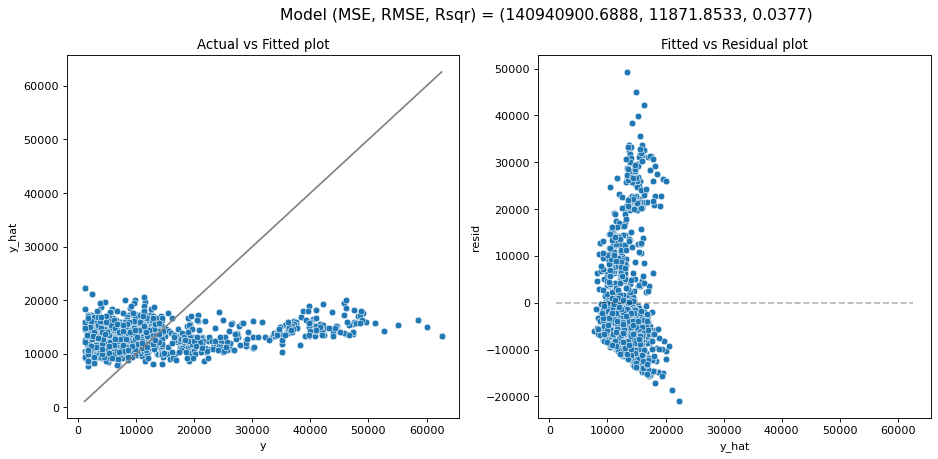

(140940900.68876714, 11871.853296295703, 0.03773846688452254)

In [22]:
# If we use the pre-defined function
model_fit(linear_fit, np.array(X_train.bmi).reshape(-1,1), y, plot = True)

### 🚩 Exercise 5 (CORE)

Consider another simple linear regression model using only `age`, similar to above. 

- Interpret the coefficients after fitting the model

- Calculate the $R^2$ score and MSE for the fitted model and comment on the values

- How do you compare two models based on two performance metrics that you obtained before.  

<details><summary><b><u>Hint</b></u></summary>
    
You can benefit the pre-defined function `model_fit` if you want
    
</details>



---

## 4. Regression with categorical variables <a id='RCV'></a>

At the end of Exercise 2, you should have noticed that most of the smokers had a positive residual while the non smokers have a negative residule. Based on these results, it should be clear that it is important that our model include information about whether or not the individual is a smoker or not. 

As such, we need a way of encoding this information into our modeling framework. To do this we need a way of converting our string / categorical variable into a numeric representation that can be included in our model matrix.

### 4.1 Dummy Coding


The most common approach for doing this is called dummy coding, in the case of a binary categorical variable it involves picking one of the two levels of the categorical variable and encoding it as 1 and the other level as 0. With Python we can accomplish this by comparing our categorical vector to the value of our choice and then casting (converting) the result to an integer type.

For example if we wanted to code `smoker` as 1 and `nonsmoker` as 0 we would do the following,

In [23]:
X_train["smoker_yes"] = (X_train.smoker == "yes").astype(int) # Returns either 0 or 1
X_train[:5]

,age,sex,bmi,children,smoker,smoker_yes
332,61,female,31.160,0,no,0
355,46,male,27.600,0,no,0
138,54,female,31.900,3,no,0
381,55,male,30.685,0,yes,1
292,25,male,45.540,2,yes,1


This is equivalent to using an indicator function in mathematical notation,

$$ 
\mathbb{1}_{s_i} = 
\begin{cases}
1 & \text {if individual $i$ is a smoker} \\
0 & \text {if individual $i$ is not a smoker}
\end{cases}
$$

Alternatively, we can defined the opposite of this where we code `smoker` as 0 and `nonsmoker` as 1,


In [24]:
X_train["smoker_no"] = (X_train.smoker == "no").astype(int) # Returns either 0 or 1
X_train[:5]

,age,sex,bmi,children,smoker,smoker_yes,smoker_no
332,61,female,31.160,0,no,0,1
355,46,male,27.600,0,no,0,1
138,54,female,31.900,3,no,0,1
381,55,male,30.685,0,yes,1,0
292,25,male,45.540,2,yes,1,0


Now that we have recoded our categorical variable, `smoker`, into a numerical variable we can fit a standard regression model with the form,

$$ y_i = \beta_0 + \beta_1 \, x_i + \beta_2 \, \mathbb{1}_{s_i} $$

which we can represent in matrix form using, $\boldsymbol{y} = \boldsymbol{X} \boldsymbol{\beta}$
where $\boldsymbol{X} = \big[ \boldsymbol{1},\, \boldsymbol{x},\, \boldsymbol{\mathbb{1}_{s}} \big]$.

Using Python, we can use the concatenate function with our 1s column, the `bmi` column, and our new dummy coded indicator column, `smoker_yes`,

In [25]:
# Selection of predictors; 1 numerical and 1 categorical
X = np.c_[np.ones(len(y_train)), 
          X_train.bmi, 
          X_train.smoker_yes]

lin_model = LinearRegression(fit_intercept=False).fit(X, y_train)

# Model parameters
beta_0 = lin_model.intercept_
print(beta_0)
beta = lin_model.coef_
print(beta)

# Using our helper function to get together
get_coefs(lin_model)

0.0
[-3632.14678352   398.47958105 23237.22457335]


array([    0.        , -3632.14678352,   398.47958105, 23237.22457335])

This gives us a regression equation of the form,

$$ 
y_i = -3632.15 + 398.48 \, x_i + 23237.22 \, \mathbb{1}_{s_i} 
$$

which can be rewritten as two separate line equations (one for each case of `smoker`),

$$
y_i = \begin{cases}
        -3632.15 + 398.48 \, x_i & \text{if individual $i$ is a not smoker} \\
        (-3632.15 + 23237.22) + 398.48 \, x_i & \text{if individual $i$ is a smoker.} \\
       \end{cases}
$$

We can calculate prediction points along those lines using the following Python code in which we hard code the possible values of $\boldsymbol{\mathbb{1}_{s_i}}$

---

Note that by including a dummy variable in our model will change the interpretation of our regression coefficients. In this context,

* $\beta_0$ - This is the expected charges for in individual with a `bmi` of zero and a `smoker` indicator of zero, in other words a nonsmoker with zero bmi.

* $\beta_1$ - This is the expected additional charges an individual would incure if their bmi were to increase by 1 unit, all else being equal.

* $\beta_2$ - This is the expected additional charges an individual would incure if their indicator were to increase by 1, all else being equal. However, the smoker indicator can only be 0 or 1 and hence this is the change in charges we would expect between a smoker and a nonsmoker with the same bmi. In other words, smokers should expect to pay $23237.22$ more for healthcare than nonsmokers.

Based on these interpretations we can see that the level that was coded as 0 (what is often called the reference level) gets folded into our intercept and the slope coefficient for the indicator provides the difference in intercept between the reference and the contrast level (level coded as 1).


In [26]:
X_train["charges_smoker_pred"] = lin_model.predict(X)
X_train["charges_smoker_pred"]

332      8784.476962
355      7365.889653
138      9079.351852
381     31832.423734
292     37751.837911
            ...     
1095     8860.188082
1130     5879.560816
1294     6399.576669
860     38572.705848
1126     8282.392690
Name: charges_smoker_pred, Length: 936, dtype: float64

---

### 🚩 Exercise 6 (CORE)

Based on these regression fits, do you think the model including the dummy coded `smoker` variable produces a "better" model than our first regression model which did not include `smoker`? How can you measure ? 

---

Add your text solution here

---

### 4.2 One hot encoding
Another common approach for transforming categorical variables is known as one hot encoding, in which all levels of the categorical variable are transformed into a new columns with values of 0 or 1. 

- This is equivalent to what we have done manually above by including both `smoker_yes` and `smoker_no`. 
- Recall that this differs from dummy coding in that there is no longer a reference factor.

Pandas has a built-in method for performing this on categorical columns. This is easiest to see with a simple example, below we construct a data frame `df` with a single column that we transform into a one hot encoded version using panda's `get_dummies` method.

In [27]:
X_train_dummy = pd.get_dummies(X_train[["bmi", "smoker"]], columns=["smoker"])
X_train_dummy[:5]

,bmi,smoker_no,smoker_yes
332,31.160,1,0
355,27.600,1,0
138,31.900,1,0
381,30.685,0,1
292,45.540,0,1


Note that `get_dummies` does not modify the underlying dataframe in place, and that it is necessary to save the result to a new variable (or overwrite the old version).

---

### 4.3 Rank deficiency <a id='LSRD'></a>

Now lets consider the model where we naively include both `smoker_yes` and `smoker_no` as well as an intercept column in our model matrix.

In [28]:
X = np.c_[
    np.ones(len(y_train)), 
    X_train.bmi, 
    X_train.smoker_yes,
    X_train.smoker_no
]

# Model calling
lin_model = LinearRegression(fit_intercept=False).fit(X, y_train)

# Model parameters
beta_0 = lin_model.intercept_
print(beta_0)
beta = lin_model.coef_
print(beta)

# Using our helper function to get together
get_coefs(lin_model)

0.0
[ 5324.31033543   398.47958105 14280.76745439 -8956.45711896]


array([    0.        ,  5324.31033543,   398.47958105, 14280.76745439,
       -8956.45711896])

This gives us a regression equation of the form,

$$
y_i = \begin{cases}
        5324.31 + 398.48 \, x_i + 14280.77(0) - 8956.46(1) \\= -3632.15 + 398.48 \, x_i & \text{if individual $i$ is not a smoker} \\
        5324.31 + 398.48 \, x_i + 14280.77(1) - 8956.46(0) \\= 19605.08 + 398.48 \, x_i & \text{if individual $i$ is a smoker.} \\
       \end{cases}
$$

- However, the solutions ($\boldsymbol{\beta}$) are not unique, anything of the form $\beta_0 + \beta_2 = a$ and $\beta_0 + \beta_3 = b$ will work. 

- In other words we have colinearity between our predictors - since the created two columns for representing smoker and non-smoker under one-hot encoding results in the intercept term (having 1s in the 1st column). 

- Mathematically, we describe this as these columns are linearly dependent, which implies that our model matrix is *rank deficient*. You can check this explicitly by via the `numpy.linalg.matrix_rank` function which will report that `X` (and $\boldsymbol{X}^\top\boldsymbol{X}$) are of rank 3 not 4 which is what we might have naively expected.

>-This is important as the underlying linear algrebra methods used to solve for $\beta$ for a least squares problem often implicitly assume that $\boldsymbol{X}^\top\boldsymbol{X}$ is full rank in order to solve the matrix inverse and violating these assumptions can have unexpected results.


---

# 5 Multiple linear regression <a id='MLR'></a>

After covering the basics of the linear regression, lets fit a baseline model with all the features to use as a point of comparison for our subsequent models.

In [29]:
full_dummies = pd.get_dummies(df_insurance, columns=["sex", "smoker"])

X = full_dummies.drop('charges',axis=1) # Independet variables
y = full_dummies['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

X = np.c_[X_train.bmi, 
          X_train.age,
          X_train.children,
          X_train.sex_female,
          X_train.smoker_yes
          ]

linreg = LinearRegression()
lm = linreg.fit(X, y_train)
beta = get_coefs(lm)
print(beta)

[-12401.78865227    333.36099462    261.91061673    432.1792927
   -136.65119758  23618.76182167]


These coefficients have the typical regression interpretation, e.g. for each unit increase in `bmi` we expect the `charges` to increase by 334.12 on average. These values are not of particular interest for us for this particular problem as we are more interested in the predictive properties of our model(s). 

- Note that in this instance we have not created the intercept column but rather allowed `sklearn` to handle this.

To evaluate this we can use the `model_fit` helper function defined above.


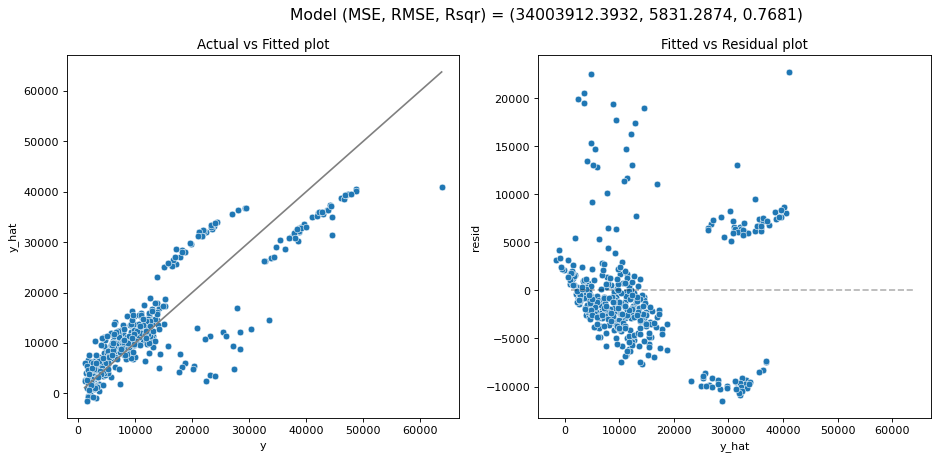

(34003912.39316076, 5831.287370140556, 0.7680881643600721)

In [30]:
X_test_matrix = np.c_[X_test.bmi, 
          X_test.age,
          X_test.children,
          X_test.sex_female,
          X_test.smoker_yes
          ]

model_fit(lm, X_test_matrix, y_test, plot = True)

Primarily we will use this function to obtain the rmse of our model using the test data (`X_test` and `y_test`). Note that we fit the model using the training data (`X_train` and `y_train`). We have also included a fit ($y$ vs $\hat{y}$) and resid ($\hat{y}$ vs $y-\hat{y}$) plot of these results.

### 🚩 Exercise 7 (CORE)

Consider a pipeline for a regression model, using sklearn functionalities 

- including both `bmi` and `age` as numerical values and smoker condition as a categorical value

- scale both `bmi` and `age` using `StandardScaler` and apply encoding for `smoker` variable within the pipeline

- Fit a model including these variables and calculate performance metrics similar to above ($R^2$, and MSE / RMSE)

---

# 6. Regularization <a id='Reg'></a>

In subsequent sections we will be exploring the use of the Ridge and Lasso regression models which both penalize larger values of $\boldsymbol{\beta}$. 

- While not particularly bad, our baseline model had $\boldsymbol{\beta}$s that ranged from the smallest at -12325 to the largest at 24263.87678352 which is about a 2x difference in magnitude.

To deal with this issue, the standard approach is to center and scale *all* features to a common scale before fitting one of these models. The typical scaling approach is to subtract the mean of each feature and then divide by its standard deviation - this results in all feature columns having a mean of 0 and a variance of 1. Additionally, the feature values can now be interpreted as the number of standard deviations each observation is away from that column's mean.

Using sklearn we can perform this transformation using the `StandardScaler` transformer from the `preprocessing` submodule.

In [31]:
from sklearn.preprocessing import StandardScaler
S = StandardScaler().fit(full_dummies.drop(['charges',"sex_male", "smoker_no"], axis=1))

Once fit, we can examine the values used for the scaling by checking the `mean_` and `var_` attributes of the transformer.

In [32]:
S.mean_

array([39.20702541, 30.66339686,  1.09491779,  0.49476831,  0.20478326])

In [33]:
S.var_

array([1.97253852e+02, 3.71600900e+01, 1.45212664e+00, 2.49972629e-01,
       1.62847076e-01])

Keep in mind, that the training and testing sets will not necessarily have the same feature column means and standard deviations - as such it is important that we choose a consistent set of values that are used for all of the data. In other words, be careful to not expect that `StandardScaler().fit_transform(X_train)` and `StandardScaler().fit(X).transform(X_train)` will give the same answer. 

- The best way to avoid this issue is to include the `StandardScaler` in a modeling pipeline for your data.

In [34]:
lm_scaled = make_pipeline(
    StandardScaler(),
    LinearRegression()
).fit(X, y_train)


get_coefs(lm_scaled)

array([13379.15730677,  1997.83119058,  3697.2463465 ,   523.79235597,
         -68.30313435,  9591.96725645])

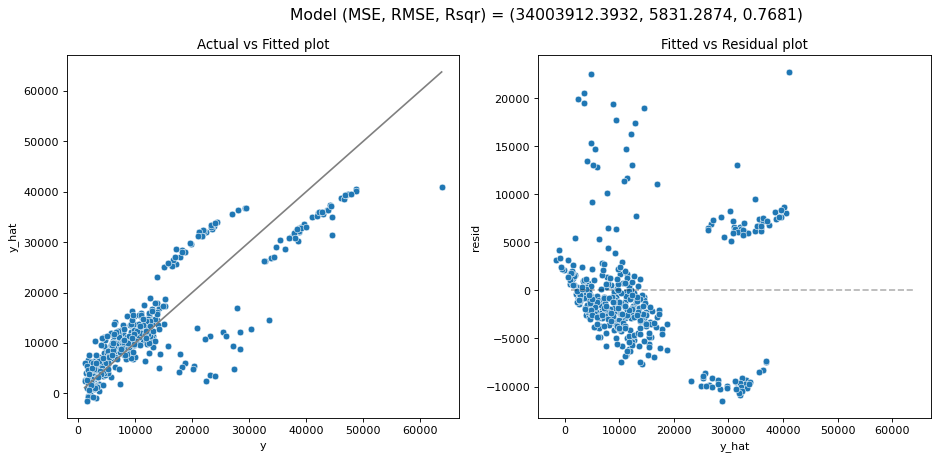

In [35]:
model_fit(lm_scaled, X_test_matrix, y_test, plot=True);

---

### 🚩 Exercise 8 (CORE)

Using this new model what has changed about our model results? Comment on both the model's coefficients as well as its predictive performance.

--- 

## 5.2 Ridge Regression

Ridge regression is a natural extension to linear regression which introduces an $\ell_2$ penalty on the coefficients to a standard least squares problem. Mathematically, we can express this as the following optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2_2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}) $$ 

The `Ridge` model is provided by the `linear_model` submodule and requires a single parameter `alpha` which determines the tuning parameter that adjusts the weight of the $\ell_2$ penalty.

- The complexity parameter $\alpha$ controls the amount of shrinkage: the larger the value of 
$\alpha$, the greater the amount of shrinkage and thus the coefficients become towards to zero. 

[13379.15730677  1838.07143505  3317.03010688   513.18421239
   -98.10337391  8648.50880121]


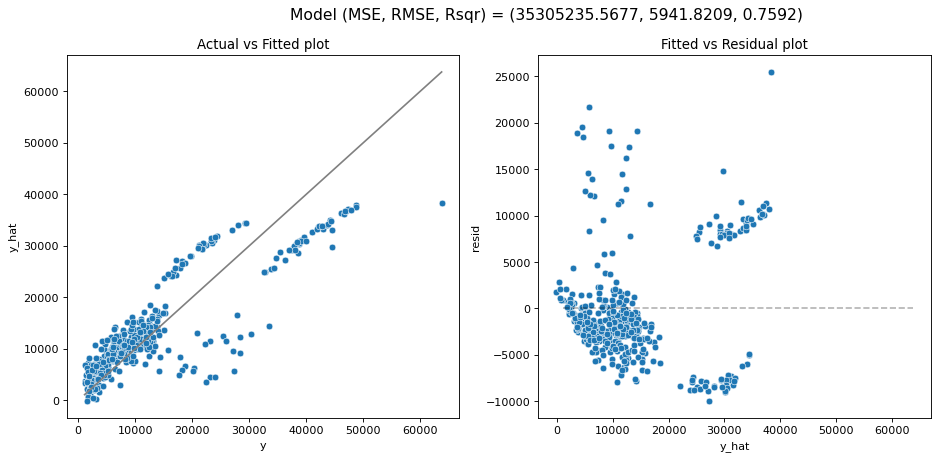

In [36]:
from sklearn.linear_model import Ridge

# Selected alpha value 
alpha_val = 100

r = make_pipeline(
    StandardScaler(),
    Ridge(alpha = alpha_val)
).fit(X, y_train)

print(get_coefs(r))

model_fit(r, X_test_matrix, y_test, plot = True); 

---

### 🚩 Exercise 9 (CORE)

Adjust the value of alpha in the cell above and rerun it. Qualitatively, how does the model fit change as alpha changes? How does the RMSE change? 

- You can try simply the following set of values and make a brief comparison, $\alpha = (1, 5, 10, 20, 100)$

---

Add your text solution here

---

### 🚩 Exercise 10 (CORE)

In Section 5.4 we mentioned the importance of scaling features before fitting a Ridge regression model. The code below fits the Ridge model to the untransformed training data. 

- How does the model fit change as alpha changes? How does the RMSE change? How does the models performance compare to the previous model?

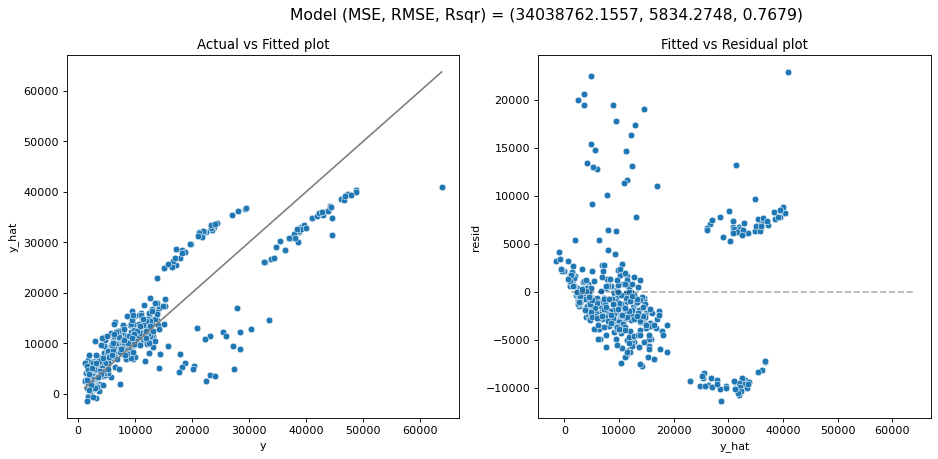

(34038762.1556884, 5834.274775470247, 0.7678504836983308)

In [37]:
r_wo_scale = make_pipeline(
    
    Ridge(alpha = 1)
).fit(X, y_train)

model_fit(r_wo_scale, X_test_matrix, y_test, plot=True)

---

Add your text solution here

---

### 5.2.1. Ridge $\beta$s as a function of $\alpha$
 
Finally, one of the useful ways of thinking about the behavior of Ridge regression models is to examine the relationship between our choice of $\alpha$ and the resulting $\beta$'s relative to the results we would have obtained from the linear regression model. Since Ridge regression is equivalent to linear regression when $\alpha=0$ we can see that as we increase the value of $\alpha$ we are shrinking all of the $\beta$s towards 0 asymptotically.

In [38]:
alphas = np.logspace(-2, 3, num=200) # from 10^-2 to 10^3

betas = [] # Store coefficients
rmses = [] # Store validation rmses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Ridge(alpha=a)
    ).fit(X, y_train)
    
    betas.append((get_coefs(m)[1:]))
    rmses.append(model_fit(m, X_test_matrix, y_test))


In [39]:
res = pd.DataFrame(
    data = betas,
    columns = full_dummies.drop(['charges','smoker_no', 'sex_male'],axis=1).columns, # Label columns w/ feature names
).assign(
    alpha = alphas,
    rmse = rmses
).melt(
    id_vars = ('alpha', 'rmse')
)

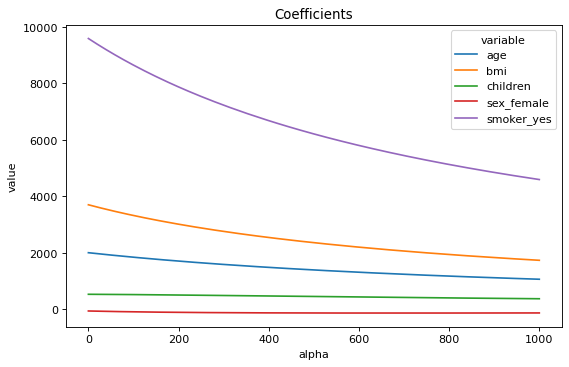

In [40]:
sns.lineplot(x='alpha', y='value', hue='variable', data=res).set_title("Coefficients")
plt.show()

---

### 🚩 Exercise 11 (EXTRA)

Based on this plot, which variable(s) seem to have non-zero coefficients for larger $\alpha$ values for predicting `charges`.

<details><summary><b><u>Hint</b></u></summary>
    
Think about what the degree of shrinkage towards 0 means in this context.
    
</details>

---

Add your text solution here

### 5.2.2. Tuning with GridSearchCV

Linear regression doesn't have any hyperparameters to tune but **Ridge** and **Lasso** regression do ($\alpha$). To start with, to tune the $\alpha$ in the Ridge regression model we can use cross validation to attempt to identify a good value for our data. 

Herein, we will start by using `GridSearchCV` to employ 5-fold cross validation to determine a good value $\alpha$.

In [41]:
alphas = np.linspace(0, 60, num=200)

gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid = {'ridge__alpha': alphas},
    cv = KFold(5, shuffle = True, random_state = 42),
    scoring = "neg_root_mean_squared_error"
)

gs.fit(X, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': array([ 0.        ,  0.30150754,  0.60301508,  0.90452261,  1.20603015,
        1.50753769,  1.80904523,  2.11055276,  2.4120603 ,  2.71356784,
        3.01507538,  3.31658291,  3.61809045,  3.91959799,  4.22110553,
        4.52261307,  4.82...
       51.25628141, 51.55778894, 51.85929648, 52.16080402, 52.46231156,
       52.7638191 , 53.06532663, 53.36683417, 53.66834171, 53.96984925,
       54.27135678, 54.57286432, 54.87437186, 55.1758794 , 55.47738693,
       55.77889447, 56.08040201, 56.38190955, 56.68341709, 56.98492462,
       57.28643216, 57.5879397 , 57.88944724, 58.19095477, 58.49246231,
       58.79396985, 59.09547739, 59.39698492, 59.69849246, 60.        ])},
             scoring='neg_root_mean_squared_error')

Note that we are passing `sklearn.model_selection.KFold(5, shuffle=True, random_state=42)` to the `cv` argument rather than leaving it to its default. This is because, sometimes the data is structured (sorted by some value) and this way we are able to ensure that the folds are properly shuffled. Failing to do this causes *very* unreliable results from the cross validation process.

Once fit, we can examine the results to determine what value of $\alpha$ was chosen as well as examine the calculated mean of the rmses.

In [42]:
print(gs.best_params_)

{'ridge__alpha': 1.507537688442211}


To evaluate this model we can access the best_estimator_ model object and use it to obtain an rmse for our validation data.

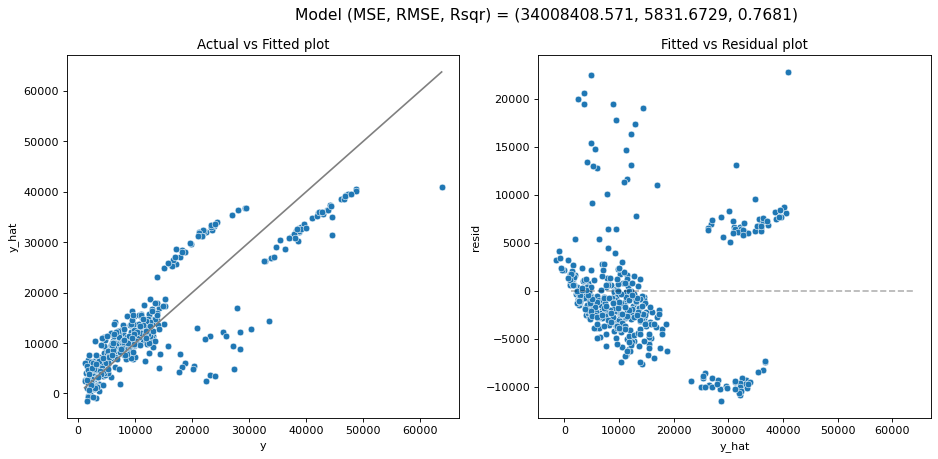

(34008408.571010634, 5831.6728792869235, 0.7680574997457632)

In [43]:
model_fit(gs.best_estimator_, X_test_matrix, y_test, plot=True)

---

## 5.3. The Lasso (EXTRA)

The Lasso is a related modeling approach to Ridge regression, but instead uses an $\ell_1$ penalty on the coefficients. Mathematically, we can express this model as the solution of the following optimization problem,

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert_2^2 + \alpha \lVert \boldsymbol{\beta} \rVert_1. $$

As with the other models from this worksheet, the `Lasso` model is also provided by the `linear_model` submodule and similarly requires the choice of the tuning parameter `alpha` to determine the weight of the $\ell_1$ penalty

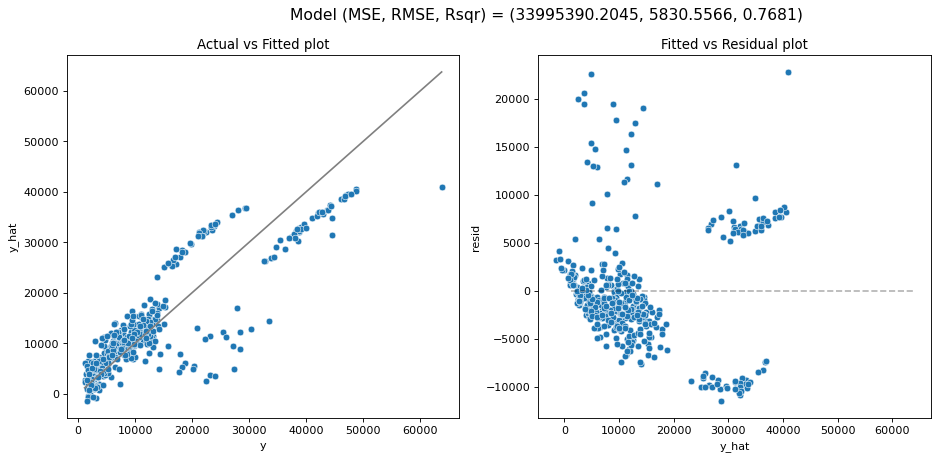

lasso coefs: [13379.15730677  1988.73367408  3688.1962497    514.71533688
   -58.84164586  9582.17067487]


In [44]:
from sklearn.linear_model import Lasso
l = make_pipeline(
    StandardScaler(),
    Lasso(alpha=10)
).fit(X, y_train)
model_fit(l, X_test_matrix, y_test, plot=True);
print("lasso coefs:", get_coefs(l))

---

### 🚩 Exercise 12 (EXTRA)

Adjust the value of $\alpha$ in the cell above and rerun it. 

- Qualitatively, how does the model fit change as $\alpha$ changes? 

- How does the RMSE change?

### 5.3.1. Lasso $\beta$s as a function of $\alpha$

As with **Ridge** regression, we can examine the values of $\beta$ we obtain as tuning parameter $\alpha$ is adjusted. 

In [45]:
alphas = np.logspace(-2, 3, num=200)
betas = [] # Store coefficients
rmses = [] # Store validation rmses

for a in alphas:
    m = make_pipeline(
        StandardScaler(),
        Lasso(alpha = a)
    ).fit(X, y_train)

    # Again ignore the intercept since it isn't included in the penalty
    betas.append(get_coefs(m)[1:])  
    rmses.append(model_fit(m, X_test_matrix, y_test))

res = pd.DataFrame(
    data = betas,       # Coefficients
    columns = full_dummies.drop(['charges','smoker_no', 'sex_male'],axis=1).columns, # Coefficient names
).assign(
    alpha = alphas,     # Add alpahs
    rmse = rmses        # Add validation rmses
).melt(
    id_vars = ('alpha', 'rmse') # Move columns into the rows
)

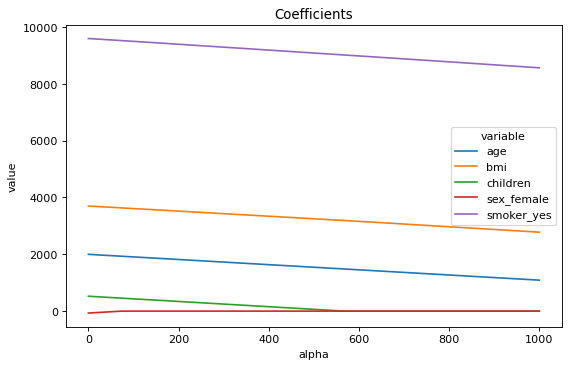

In [46]:
sns.lineplot(x = 'alpha', y = 'value', hue = 'variable', data = res).set_title("Coefficients")
plt.show()

To further explore this choice of $\alpha$, we can collect relevant data about the folds and their performance from the `cv_results_` attribute. In this case we are particularly interested in examining the `mean_test_score` and the `split#_test_score` keys since these are used to determine the optimal $\alpha$ value.

In the code below we extract these data into a data frame by selecting our columns of interest along with the  αα  values used (and transform negative rmse values into positive values).

In [47]:
cv_res = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score'
).assign(
    # Add the alphas as a column
    alpha = alphas
)

cv_res.update(
    # Convert negative rmses to positive
    -1 * cv_res.filter(regex = '_test_score')
)

This data frame can then be used to plot $\alpha$ against the root mean squared value over the 5 folds, to produce the following plot.

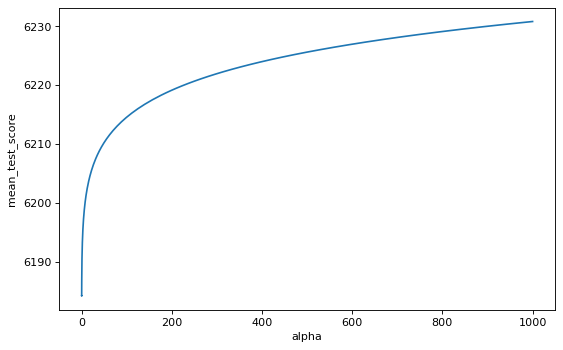

In [48]:
sns.lineplot(x='alpha', y='mean_test_score', data=cv_res)
plt.show()

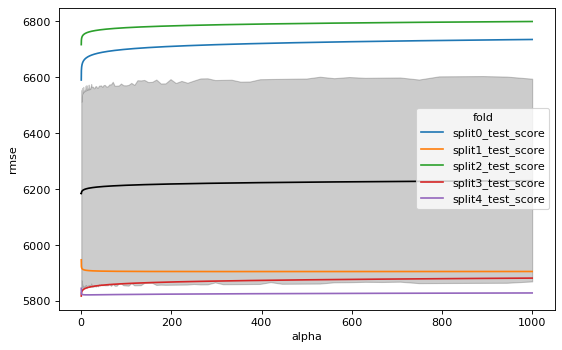

In [49]:
d = cv_res.melt(
    id_vars=('alpha','mean_test_score'),
    var_name='fold',
    value_name='rmse'
)

sns.lineplot(x='alpha', y='rmse', color='black', data = d)  # Plot the mean rmse +/- the std dev of the rmse.
sns.lineplot(x='alpha', y='rmse', hue='fold', data = d) # Plot the curves for each fold
plt.show()

## 6. Polynomial Regression

For this part, we will be using a synthetic data that was generated from a Gaussian Process model. 

- The resulting data represent an unknown smooth function $y = f(x) + \epsilon$. We will be implementing a variety of approaches for deriving a parameterized model of this function using least squares regression.

- We can read the data in from `gp.csv` and generate a scatter plot to get a sense of the shape of the function.

<AxesSubplot:xlabel='x', ylabel='y'>

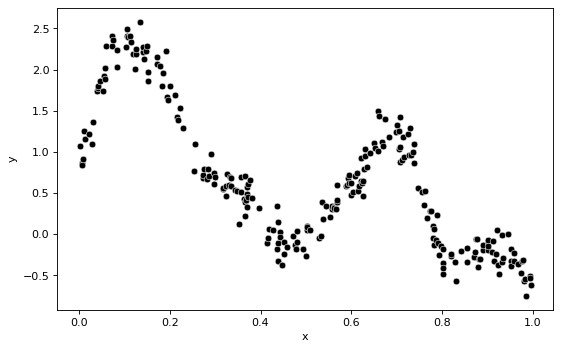

In [50]:
synt_df = pd.read_csv("gp.csv")

sns.scatterplot(x = 'x', y = 'y', data = synt_df , color="black")

We can easily observe that the generated data includes a non-linear relationship between x and y. The implementation of Linear regression is not reasonable anymore and we will focus more on polynomial regression for this specific data. 

- Since the data is a simulated one, we do not have to deal with pre-processing right now but focus more on about the polynomial modeling here

### 6.1 Sklearn for polynomial features

sklearn has a built in function called `PolynomialFeatures` which can be used to simplify the process of including polynomial features in a model. This function is included in the *preprocessing* module of sklearn, as with other python functions we can import it as follows.

In [51]:
from sklearn.preprocessing import PolynomialFeatures

Construction and use of this and other transformers is similar to what we have already seen with LinearRegression, we construct a PolynomialFeatures object in which we set basic options (e.g. the degree of the polynomial) and then apply the transformation to our data via fit_transform method. This will generate a new model matrix which includes the polynomial features up to the degree we have specified.

To demonstrate the core features we will start with a toy example and then replicate the models we constructed in Section 3.1. Below we construct our sample data vector and then pass it into the transformer,

In [52]:
x = np.array([1, 2, 3, 4]) # Initial data
PolynomialFeatures(degree = 2).fit_transform(x)

ValueError: Expected 2D array, got 1D array instead:
array=[1 2 3 4].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

- When we run the above code we get an error because currently x is a 1D vector when the `fit_transform` function is expected a **2D array** (the same will also happen with LinearRegression's fit method). 

- To solve this we need to make sure that the value we pass has the correct dimensions, `x.reshape(-1, 1)` is suggested by the error and corrects the issue.

In [53]:
PolynomialFeatures(degree = 2).fit_transform(x.reshape(-1,1))

# Alternatively, we can alsu use the np.c_ function to construct the matrix.
# PolynomialFeatures(degree = 2).fit_transform(np.c_[x]) # Order 2 polynomial model matrix for x

array([[ 1.,  1.,  1.],
       [ 1.,  2.,  4.],
       [ 1.,  3.,  9.],
       [ 1.,  4., 16.]])

Note that when we use this transform, we get **all of the polynomial transformations of x from 0 to degree**. 

In this case, the **0 degree column** is equivalent to **the intercept column**. If for some reason we did not want to include this we can construct `PolynomialFeatures` with `include_bias=False`.

In [54]:
PolynomialFeatures(degree = 2, include_bias=False).fit_transform(np.c_[x])

array([[ 1.,  1.],
       [ 2.,  4.],
       [ 3.,  9.],
       [ 4., 16.]])

### 6.2. Pipelines 

You may have noticed that `PolynomialFeatures` takes a model matrix as input and returns a new model matrix as output which is then used as the input for `LinearRegression`. This is not an accident, and by structuring the library in this way sklearn is designed to enable the connection of these steps together, into what sklearn calls a *pipeline*.

We can modularize and simply our code somewhat by creating a pipeline that takes our original data, performs a polynomial feature transform and then feeds the results into a linear regression. We can accomplish this via the `make_pipeline` function from the `pipeline` module. 

- The resulting object represents a new "model" which can then be fit to data.

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(
    PolynomialFeatures(degree = 3),
    LinearRegression()
)

print(poly_model)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])


In [56]:
synt_df.x.to_numpy()[:5]

array([0.00218943, 0.00620852, 0.00676406, 0.00934857, 0.01240698])

In [57]:
# Convert the data frame to numpy array and reshaping
array_x = synt_df.x.to_numpy().reshape(-1, 1)

poly_reg = poly_model.fit(array_x, synt_df.y)
print(poly_reg)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])


- The returned object is a `Pipeline` object so it will not provide direct access to step properties, such as the coefficients for the regression model.

- If we want access to the attributes or methods of a particular step we need to first access that step using either its name or position.

In [58]:
print(poly_reg.named_steps['linearregression'].coef_)

[ 0.         -8.49429068 13.95066369 -8.39215284]


In [59]:
print(poly_reg.steps[1][1].intercept_) # second subset is necessary here because 
                                       # each step is a tuple of a name and the 
                                       # model / transform object 

2.369856838103899


Also note that both the `'linearregression'` and `'polynomialfeatures'` step introduce a column of ones into the model matrix. This potentially introduces a rank deficiency in our model matrix, however sklearn handles this by fixing the coefficient of the duplicate intercept column to 0. The result however is that the intercept is now stored in `intercept_` and not `coef_`. If we wished to avoid this we would need to construct our pipeline using `LinearRegression(fit_intercept=False)`.

In [60]:
p = make_pipeline(
    PolynomialFeatures(degree = 3),
    LinearRegression(fit_intercept = False)
).fit(
    array_x,
    synt_df.y
)

print(p.named_steps['linearregression'].coef_)
print(p.named_steps['linearregression'].intercept_)

[ 2.36985684 -8.49429068 13.95066369 -8.39215284]
0.0


### 6.3. Choosing the Order of Polynomial

So far each time we've wanted to fit a **polynomial regression model** we've had to set up the various data objects and then create the sklearn model and transformation objects and then get a final result of the coefficients or a plot - because of this the preceeding cells contain a lot of duplicated code which is something we should be trying to avoid. 

Additionally, in the lecture we discussed how chosing $M$ to be too large can cause over fittting. When we over fit a polynomial regression model, the MSE for the training data will appear to be low which might indicate that the model is a good fit. As a result of over fitting, the MSE for the predictions of the unseen test data may begin to decrease. We will illustrate this next.

First, we will read in clean data and create our training and testing subsets.

In [61]:
from sklearn.model_selection import train_test_split

X = synt_df.drop('y',axis=1) # Independet variable
y = synt_df['y'] # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#full datasets for plotting purposes
train_full = X_train.join(y_train)
test_full = X_test.join(y_test)

Next, consider the `poly_reg_mse` function given below so that it can take as input a **training dataset** and a **testing data** set. The new function will return the **MSE** for both the train and test dataset (as well as a plot with black representing the training points and red representing the testing points.

In [62]:
def poly_reg_mse(train_data, test_data, x = 'x', y = 'y', degree=1, plot_data = True, plot_fit = True):
    
    X = np.c_[train_data[x]]
    Y = train_data[y]
    
    p = make_pipeline(
        PolynomialFeatures(degree=degree),
        LinearRegression(fit_intercept=False)
    )
    
    m = p.fit(X,Y)
    
    pred_col = 'pred_d'+str(degree)
    train_data[pred_col] = m.predict(X)
    test_data[pred_col] = m.predict(np.c_[test_data[x]])
    if plot_data:
        sns.scatterplot(train_data[x],train_data[y], color="black")
        sns.scatterplot(test_data[x],test_data[y], color="red")

    if plot_fit:
        sns.lineplot(train_data[x],train_data[pred_col])

    test_mse = mean_squared_error(test_data[y], test_data[pred_col])
    train_mse = mean_squared_error(train_data[y], train_data[pred_col])
  
    return (test_data, m.steps[1][1], train_mse, test_mse)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.0728055009288664
0.08807022273835378


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


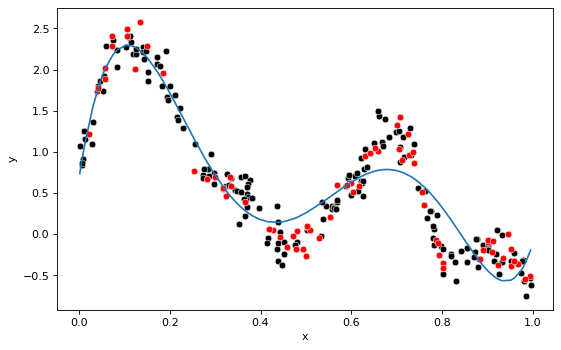

In [63]:
test_data_col, steps, mse_train, mse_test = poly_reg_mse(train_data = train_full, test_data = test_full, degree = 6)
print(mse_train)
print(mse_test)

### 🚩 Exercise 13 (EXTRA)

- Change the values for degree. What do you notice about the fit as we increase the polynomial degree? 
- Which degree seems better regarding the changes on training and testing MSE values ?

### 6.4 Tunning with GridSearchCV

If we wish to test over a specific set of parameter values using cross validation we can use the `GridSearchCV` function from the `model_selection` submodule. In this setting, the hyperparamer is actually the degree of the polynomial that we are investigating. 

This argument is a dictionary containing parameters names as keys and lists of parameter settings to try as values. Since we are using a pipeline, out parameter name will be the name of the pipeline step, `polynomialfeatures`, followed by `__`, and then the parameter name, `degree`. So for our pipeline the parameter is named `polynomialfeatures__degree`. If you want to list any models available parameters you can call the `get_params()` method on the model object, e.g. `m.get_params()` here.

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

m = make_pipeline(
        PolynomialFeatures(),
        LinearRegression(fit_intercept=False)
    )

parameters = {
    'polynomialfeatures__degree': np.arange(1,31,1)
}

kf = KFold(n_splits = 5, shuffle = True, random_state=42)

grid_search = GridSearchCV(m, parameters, cv = kf).fit(X, y)

The above code goes through the process of fitting all $5 \times 30$ models as well as storing and ranking the results for the requested scoring metric(s). Note that here we have used `neg_mean_squared_error` as our scoring metric which returns the **negative of the root mean squared error**. 

- As the name implies this returns the negative of the usual fit metric, this is because sklearn expects to always optimize for the maximum of a score and the model with the largest negative MSE will therefore be the "best". 

- In this workshop we have used MSE as a metric for testing our models. This metric is entirely equivalent to the root mean squared error for purposes of ranking / ordering models (as the square root is a monotonic transformation). Sometimes the RMSE is prefered as it is more interpretable, because it has the same units as $y$.

Once all of the submodels are fit, we can determine the optimal hyperparameter value by accessing the object's `best_*` attributes,

In [65]:
print("best index: ", grid_search.best_index_)
print("best param: ", grid_search.best_params_)
print("best score: ", grid_search.best_score_)

best index:  16
best param:  {'polynomialfeatures__degree': 17}
best score:  0.9636450321209328


### Further resources

- About common pitfalls and variable importance: 

https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#